In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
import copy
import pandas as pd
import random
import seaborn as sns

In [ ]:
df = pd.read_csv ("True_model.csv")

x = df['周波数 [MHz]\n']
y = df['FG model + 21cm model + error[K]\n']
data = y
frequency = x
data_21_FG_error = y
nu_c = 75.0

In [ ]:
def AIC(r2, k):
    Se = np.sum( (r2/0.025)**2 )
    L = np.exp( - Se / 2 )
    return - 2 * np.log( L ) + 2*k 

def BIC(r2,k):
    n = 103
    Se = np.sum( (r2/0.025)**2)
    L = np.exp( - Se / 2 )
    return - 2 * np.log( L ) +  k * np.log(n)

def f(x,a,b,c,d,e):
  return e*np.power((x/nu_c),4-2.5)\
  +d*np.power((x/nu_c),3-2.5)\
  +c*np.power((x/nu_c),2-2.5)\
  +b*np.power((x/nu_c),1-2.5)\
  +a*np.power((x/nu_c),0-2.5)
  
def GSmodel(x, p0, p1, p2, p3):
    A_21 = p0
    nu_21 = p1
    w_21 = p2
    tau_21 = p3
    B_21 = 4 * np.power(x-nu_21,2) /w_21/w_21 \
        * np.log(-np.log((1+np.exp(-1*tau_21))*0.5)/tau_21)
    T_21 = -1*A_21 * (1-np.exp(-1*tau_21 * np.exp(B_21))) / (1-np.exp(-1*tau_21))
    return T_21
    
def fgs(x, a, b, c, d, e, p0, p1, p2, p3):
    return f(x, a, b, c, d, e) + GSmodel(x, p0, p1, p2, p3)
p_init = np.array([100, 10, 1, 1, 1, 0.5, 78, 18, 8])
Fit_y, cov = curve_fit(fgs, frequency, data_21_FG_error, p0=p_init, maxfev=10000)

print(Fit_y)

r1 = y - fgs(x, Fit_y[0], Fit_y[1], Fit_y[2], Fit_y[3], Fit_y[4], Fit_y[5], Fit_y[6], Fit_y[7], Fit_y[8])
print( np.mean(r1**2)**0.5 )

[ 1.78916241e+03  1.33048211e+02 -2.74333083e+02  1.15149851e+02
 -1.23424603e+01  4.80045658e-01  7.83930685e+01  1.91013192e+01
  1.02358840e+01]
0.026853571217129175


In [ ]:
def P(x, a, b, c, d, e, p0, p1, p2, p3):
    r1 = y - fgs(x, a, b, c, d, e, p0, p1, p2, p3)
    return ( np.mean(r1**2) )**0.5

def Q(c,  w ):
    return (c[0] + w[0] * np.random.normal(0, 1), c[1] + w[1] * np.random.normal(0, 1)
           ,c[2] + w[2] * np.random.normal(0, 1), c[3] + w[3] * np.random.normal(0, 1)
           ,c[4] + w[4] * np.random.normal(0, 1), c[5] + w[5] * np.random.normal(0, 1)
           ,c[6] + w[6] * np.random.normal(0, 1), c[7] + w[7] * np.random.normal(0, 1)
           ,c[8] + w[8] * np.random.normal(0, 1)
           )

def ran_Q(c,  w, A ):
    c[A] = c[A] + w[A] * np.random.normal(0, 1)
    return c

def up_w( w, A ):
    w[A] = w[A] * 1.02
    return w

def down_w( w, A ):
    w[A] = w[A] / 1.02
    return w

In [ ]:
x = (1, 1)
np.(x**2)

In [ ]:
def pre_metropolis( N, w, current):
   
    accept_ratio = []
    A = 0
    for i in range(N):
        
        if A == 9 :
            A = 0
            
        current_1 = copy.copy( current )
        candidate = copy.copy( ran_Q(current_1 , w = w, A = A) )
        A = A + 1
        
        T_prev = P(x,current[0], current[1], current[2], current[3],current[4], current[5],current[6], current[7], current[8],)
        T_next = P(x,candidate[0], candidate[1], candidate[2], candidate[3],candidate[4],candidate[5],candidate[6],candidate[7], candidate[8])
        
        a = T_prev / T_next

        if a > 1:
            
            # Update state
            current = copy.copy(candidate)
            accept_ratio.append(i)
        
        elif a <= 1 and  a  > np.random.uniform(0, 1):
        
            # Update state
            current = copy.copy(candidate)
            accept_ratio.append(i)
        else:
            pass
    
    return float(len(accept_ratio)) / N, current

In [ ]:
def metropolis(N, w, current):
    df = pd.DataFrame(columns=[ 'a', 'b', 'c', 'd','e','p0','p1','p2','p3','chi','a_'])
    accept_ratio = []
    j = 0
    A = 0
    
    for i in range(N):
        
        if (i+1) % int ( N / 5 ) == 0:
            print( (i+1) / N * 100,'%')
        
        if A == 9 :
            A = 0
            
        current_1 = copy.copy( current )
        candidate = copy.copy( ran_Q(current_1 , w = w, A = A) )
        A = A + 1
        
        T_prev = P(x,current[0], current[1], current[2], current[3],current[4], current[5],current[6], current[7], current[8],)
        T_next = P(x,candidate[0], candidate[1], candidate[2], candidate[3],candidate[4],candidate[5],candidate[6],candidate[7], candidate[8])
        
        a = T_prev / T_next

        if a > 1:
       
            j = j + 1
        
            # Update state
            current = copy.copy(candidate)
            accept_ratio.append(i)
            insert = np.concatenate([ candidate, np.array([ T_next , a] )], 0)
            
            df.loc[j - 1] = insert
        
        elif a < 1 and  a  > np.random.uniform(0, 1):
            
            j = j + 1
            # Update state
            current = copy.copy(candidate)
            accept_ratio.append(i)
            insert = np.concatenate([ candidate, np.array([ T_next , a] )], 0)
            df.loc[j - 1] = insert 
            
        else:
            pass
            
    print('Accept ratio:', float(len(accept_ratio)) / N)
    
    print(current)
    
    return df, j 

In [ ]:
def main( N1, N2, rangeN, burn_in, w , current):
    
    start_time = time.time()
    
    w = copy.copy( w )
    
    current = copy.copy( current )
    
    B = 0
    C = 0
    
    for i in range(rangeN):
        
        if (i+1) % int ( rangeN / 100 ) == 0: 
            C = C + 1
            
        if C == 9:
            C = 0
            
        Accept_ratio, current = pre_metropolis(N = N1, w = w, current = current)
        
        if (i+1) % int ( rangeN / 100 ) == 0:
            print('{}%'.format( round( (i+1) / rangeN * 100) ) )
            print('Accept ratio:', Accept_ratio ) 
            print( 'current={} w = {}'.format(current, w) )
            print('chi=',P(x,current[0], current[1], current[2], current[3],current[4], current[5],current[6], current[7], current[8]))
        else:
            pass
    
        if Accept_ratio > 0.35:
            
            w = copy.copy( up_w( w, C ) )

        elif Accept_ratio < 0.30:
         
            w = copy.copy( down_w( w, C ) )

        elif 0.30 < Accept_ratio < 0.35:
            
            B = B + 1
            if B ==5:
                break
                
    end_time = time.time()
    elapsed_time = end_time - start_time
    print( 'take', round(elapsed_time / 60 , 2) , 'min' )
                
    print('_'*100)
    
    print( 'start mcmc current = {}, w = {}'.format( current , w ) )
    
    df, j = metropolis( N = N2 , w = w, current = current )
    
    drop_idx = []
    for i in range( int(j * burn_in)):
         drop_idx.append(i)
    df = df.drop(drop_idx, axis=0)
    
    print(df)
    
    print(df.describe())
    
    best_chi_num = df['chi'][df['chi'] == df['chi'].min()].index[0]
    
    print(best_chi_num)
    print( df.loc[best_chi_num] )
    
    chi = df['chi']
    plt.plot(range(1,len(chi)+1), chi)
    
    df = df.drop( columns = 'a_')  
    df = df.drop( columns = 'chi') 
    
    end_time = time.time()
    elapsed_time = end_time - start_time
          
    sns.pairplot(df, plot_kws = {'alpha':0.5},corner=True, kind="kde" ) #,diag_kind='kde , 'corner=Trueplt.show() 
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print( 'take', round(elapsed_time / 60 , 2) , 'min' )
    plt.show()

レプリカ交換法
温度の導入　→ 尤度ポテシャルの凸凹を調整する　→ 局所にとらわれない

In [ ]:
# 2500回のサンプリングを１０００回した
current=np.array(
    [ -73.483266, 3371.422153, -1892.811448, 1643.989483, 308.981153,
     1599.221313, -533.390065, 1606.875353, 2441.980152,])
w = np.array( [9.00780686, 9.18796299, 9.00780686, 9.00780686, 9.00780686, 9.00780686,
 9.00780686, 9.00780686, 9.00780686] )

In [ ]:
main(N1 = 2500, rangeN = 1000, N2 = 300000, burn_in = 0.1, w = w , current = current)

1%
Accept ratio: 0.9996
current=[  248.51066682  3550.69653707 -1309.17805576  2554.42981052
   138.13822294   826.6235972  -1148.19342021  1824.30016809
  2647.46207073] w = [10.76516304  9.18796299  9.00780686  9.00780686  9.00780686  9.00780686
  9.00780686  9.00780686  9.00780686]
chi= 35001.482362279115
2%
Accept ratio: 0.9992
current=[  170.49811588  3786.37132586 -2665.35781273  2729.54147169
   207.06535923   883.93153599  -489.37886071  2511.25408066
  2054.56276407] w = [10.76516304 11.20007562  9.00780686  9.00780686  9.00780686  9.00780686
  9.00780686  9.00780686  9.00780686]
chi= 16758.420309692825


KeyboardInterrupt: 

0.02795896351007696
rms = 0.02795896351007106


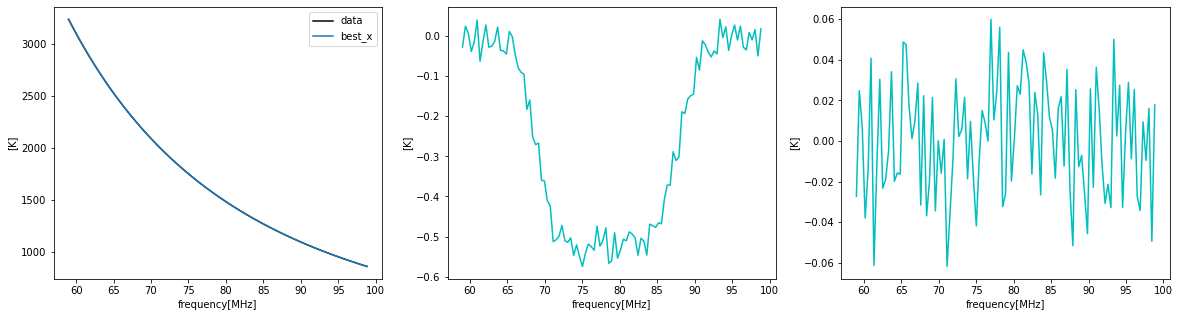

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(131)
ax.plot(frequency, data, color="k", label="data")
ax.plot(frequency, f(x, best_x[0], best_x[1], best_x[2], best_x[3], best_x[4]), label="best_x")
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")
ax.legend(loc="upper right")

r1 = data - f(x, best_x[0], best_x[1], best_x[2], best_x[3], best_x[4]) 
r2 = data - f(x, best_x[0], best_x[1], best_x[2], best_x[3], best_x[4]) - GSmodel(x,best_x[5], best_x[6], best_x[7], best_x[8],)
print(P(x, best_x[0], best_x[1], best_x[2], best_x[3], best_x[4],best_x[5], best_x[6], best_x[7], best_x[8]))
ax = fig.add_subplot(132)
ax.plot(frequency, r1, color="c")
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

ax = fig.add_subplot(133)
ax.plot(frequency, r2, color="c")
ax.set_xlabel("frequency[MHz]")
ax.set_ylabel("[K]")

print("rms = {}".format( ( np.mean(r2**2) )**0.5 ) )

plt.show()

In [ ]:
def P(x, a, b):
    r1 = y - ( a * x + b )
    return ( np.mean(r1**2) )**0.5
# Q(x) : Proposal distribution
def Q(c,  w ):
    return ( c[0] + w[0] * np.random.normal(0, 1), c[1] + w[1] * np.random.normal(0, 1) )

def ran_Q(c,  w, A ):
    c[A] = c[A] + w[A] * np.random.normal(0, 1)
    return c

def metropolis(N, current ,w):
    df = pd.DataFrame(columns=[ 'a', 'b','chi','a_']
    accept_ratio = []
    j = 0
    A = 0
    
    for i in range(N):
        
        if ( i + 1 ) % int ( N / 5 ) == 0:
            end_time = time.time()
            elapsed_time = end_time - start_time
            print( (i+1) / N * 100,'take {} min'.format( elapsed_time/60 ) )
        
        if A == 2 :
            A = 0
            
        current_1 = copy.copy( current )
        candidate = copy.copy( ran_Q(current_1 , w = w, A = A) )
        A = A + 1
        
        T_prev = P(x,current[0], current[1])
        T_next = P(x,candidate[0], candidate[1])
        
        a = T_prev / T_next

        if a > 1:
            
            j = j + 1
        
            # Update state
            current = copy.copy(candidate)
            accept_ratio.append(i)
            insert = candidate + [ T_next , a ]
            
            df.loc[j - 1] = insert
        
        elif a < 1 and  a  > np.random.uniform(0, 1):
            
            j = j + 1
            # Update state
            current = copy.copy(candidate)
            accept_ratio.append(i)
            insert = candidate + [ T_next, a ]
            
            df.loc[j - 1] = insert 
        else:
            pass
        
    print( 'Accept ratio:', float(len(accept_ratio)) / N )
    return df, j, accept_ratio


def main(N,burn_in, w):
    
    start_time = time.time()
    
    df, j,  accept_ratio = metropolis(N = N, w = w)
    
    chi = df['chi']
    plt.plot( range( 1 , len(accept_ratio) + 1 ) , chi)
    
    drop_idx = []
    for i in range( int(j * burn_in)):
         drop_idx.append(i)
    df = df.drop(drop_idx, axis=0)
    
    print(df)
    
    print(df.describe())
    
    
    best_chi_num = df['chi'][df['chi'] == df['chi'].min()].index[0]
    
    print( df.loc[best_chi_num] )
        
    df = df.drop( columns = 'a_')  
    df = df.drop( columns = 'chi') 
    
    end_time = time.time()
    elapsed_time = end_time - start_time
          
    sns.pairplot(df, plot_kws = {'alpha':0.5},corner=True, kind="kde" ) #,diag_kind='kde , 'corner=Trueplt.show() 
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print( 'take', round(elapsed_time / 60 , 2) , 'min' )
    plt.show()

20.0
40.0
60.0
80.0
100.0
Accept ratio: 0.9202039215686274
                a            b         chi        a_
93860  -38.054045  4381.894301  412.208212  1.012244
93861  -41.394520  4381.894301  628.225429  0.656147
93862  -41.394520  4388.852815  621.746262  1.010421
93863  -41.441748  4388.852815  625.069701  0.994683
93864  -41.441748  4399.365020  615.290690  1.015893
...           ...          ...         ...       ...
234647 -55.244476  6295.111866  281.885942  0.965790
234648 -56.441977  6295.111866  209.894103  1.342991
234649 -56.441977  6277.517513  198.566621  1.057046
234650 -56.785120  6277.517513  183.304313  1.083262
234651 -56.785120  6279.099047  184.134162  0.995493

[140792 rows x 4 columns]
                   a              b            chi             a_
count  140792.000000  140792.000000  140792.000000  140792.000000
mean      -11.936293    4371.881307    7839.994044       1.040569
std       161.919154    1244.727145   10100.063969       0.388059
min      -636.

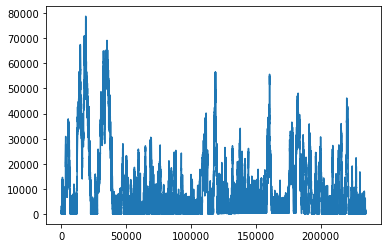

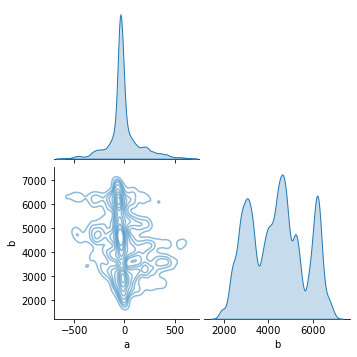

In [ ]:
main(N = 255000, burn_in = 0.4,  current = [ -60, 6000], w = [10,10] )

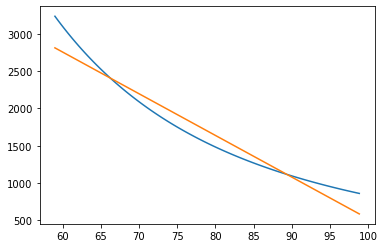

In [ ]:
plt.plot(x,y)
plt.plot(x, -55.870299 * x + 6107.405772 )

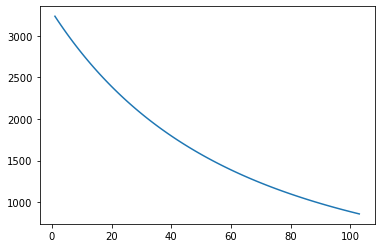

In [ ]:
plt.plot( range(1,104), y)

pandas じゃなくて　numpyでやる

In [ ]:
s